In [2]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings('ignore')
plt.ion()

In [3]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1,2)
print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


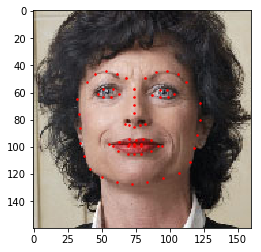

In [4]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:,0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)
plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/',img_name)),landmarks)
plt.show()

## 数据集类

In [5]:
class FaceLandmarksDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1,2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

0 (324, 215, 3) (68, 2)
1 (500, 333, 3) (68, 2)
2 (250, 258, 3) (68, 2)
3 (434, 290, 3) (68, 2)


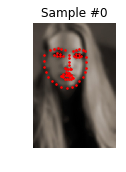

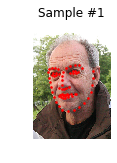

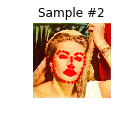

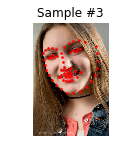

In [6]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

## 转换 Transforms

In [7]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w =image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks *[new_w/w, new_h/h]
        return {'image':img, 'landmarks':landmarks}

class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h,
                left: left + new_w]
        landmarks = landmarks - [left, top]
        return {'image':image, 'landmarks':landmarks}

class ToTensor(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## 组合转换

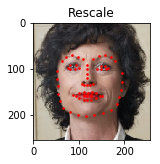

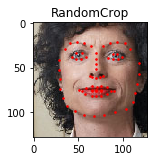

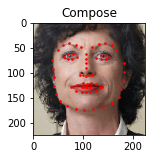

In [8]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transform_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transform_sample)
plt.show()


## 迭代数据集

In [9]:
transform_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                         root_dir='data/faces/',
                                         transform=transforms.Compose([
                                             Rescale(256),
                                             RandomCrop(224),
                                             ToTensor()
                                         ]))
for i in range(len(transform_dataset)):
    sample = transform_dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size())
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


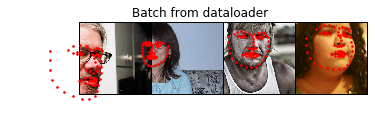

In [10]:
dataloader = DataLoader(transform_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

def show_landmarks_batch(sample_batched):
    
    images_batch, landmarks_batch = \
        sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')
        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

